**Question 1: Image Captioning **

  * Image Captioning is the process of generating textual description of an image. It uses both Natural Language Processing and Computer Vision to generate the captions. 
  * The dataset will be in the form [image → captions]. The dataset consists of input images and their corresponding output captions.

In [2]:
#import lib

from os import listdir
from pickle import dump
from pickle import load

import pandas as pd
from google.colab import drive

import re
from nltk.stem import WordNetLemmatizer

import nltk
nltk.download('wordnet')

import tensorflow as tf

from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.regularizers import l2

from keras.preprocessing.text import Tokenizer

from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np

from keras.models import Model
from keras.layers import Input , Dense , LSTM , Embedding , Dropout
from keras.layers.merge import add
from keras.callbacks import EarlyStopping

from keras.models import load_model
import matplotlib.pyplot as plt

from IPython.display import Image,display

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [4]:
drive.mount('/content/drive')
path = "/content/drive/My Drive/110_DL_Assignment_2/"

Mounted at /content/drive


In [11]:
# read pkl file
img_captions = pd.read_pickle(path+'set_0.pkl')

In [12]:
img_ids = []
captions = []

for img_caption in img_captions:
  img_caption_data = img_caption.split('\t')
  captions.append(img_caption_data[1])
  img_caption_id_data = img_caption_data[0].split('#')
  img_ids.append(img_caption_id_data[0])

In [13]:
img_caption_df = pd.DataFrame({'img_id': img_ids, 'caption':captions})

In [14]:
img_caption_df.head()

,img_id,caption
0,318667317_108c402140.jpg,A man in a black hoodie be hold a paper sign .
1,2072574835_febf0c5fb9.jpg,Three race dog be run out of the start gate on...
2,3083016677_5782bc337c.jpg,Two motorcycle with two rider each .
3,95734038_2ab5783da7.jpg,A man on a bike nest to a river .
4,241346146_f27759296d.jpg,A football player try tackle another player wh...


In [15]:
lemma = WordNetLemmatizer()

def clean_text(desc):
    
    # clean punctuation
    desc = re.sub(r'[^\w\s]' ,'', desc)
    
    # tokenize the words
    desc = desc.split()
    
    # convert to lower case
    desc = [token.lower() for token in desc]
    
    # lemmatization
    desc = [lemma.lemmatize(token) for token in desc]
    
    # remove numerical values
    desc = [token for token in desc if token.isalpha()]
    
    # join whole token
    desc = ' '.join(desc)
    
    return desc

In [16]:
img_caption_df['clean_caption'] = img_caption_df['caption'].apply(lambda x : clean_text(str(x)))

In [17]:
img_caption_df.head()

,img_id,caption,clean_caption
0,318667317_108c402140.jpg,A man in a black hoodie be hold a paper sign .,a man in a black hoodie be hold a paper sign
1,2072574835_febf0c5fb9.jpg,Three race dog be run out of the start gate on...,three race dog be run out of the start gate on...
2,3083016677_5782bc337c.jpg,Two motorcycle with two rider each .,two motorcycle with two rider each
3,95734038_2ab5783da7.jpg,A man on a bike nest to a river .,a man on a bike nest to a river
4,241346146_f27759296d.jpg,A football player try tackle another player wh...,a football player try tackle another player wh...


In [18]:
img_caption_df.to_csv(path+'img_caption_df.csv')

In [19]:
img_caption_df['img_id'].is_unique

False

In [20]:
img_caption_df.count()

img_id           25000
caption          25000
clean_caption    25000
dtype: int64

In [21]:
file_names = []
for name in listdir(path+'Flicker8k_Dataset'):
  file_names.append(name)
print(len(file_names))

8091


In [22]:
img_caption_df = img_caption_df[ img_caption_df['img_id'].isin(file_names)]

In [23]:
img_caption_df.head()

,img_id,caption,clean_caption
0,318667317_108c402140.jpg,A man in a black hoodie be hold a paper sign .,a man in a black hoodie be hold a paper sign
1,2072574835_febf0c5fb9.jpg,Three race dog be run out of the start gate on...,three race dog be run out of the start gate on...
2,3083016677_5782bc337c.jpg,Two motorcycle with two rider each .,two motorcycle with two rider each
3,95734038_2ab5783da7.jpg,A man on a bike nest to a river .,a man on a bike nest to a river
4,241346146_f27759296d.jpg,A football player try tackle another player wh...,a football player try tackle another player wh...


In [24]:
img_caption_df.count()

img_id           24996
caption          24996
clean_caption    24996
dtype: int64

In [ ]:
# use GPU if available
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
# extrat Features
def extract_features(directory):
  with tf.device('/device:GPU:0'):
    
    model = VGG16()
    
    #remove last layer
    model.layers.pop()
    
    model = Model(inputs = model.inputs , outputs = model.layers[-2].output)
    
    print(model.summary())
    
    features = dict()
    
    for name in listdir(directory):
        
        # load and image
        filename = directory + '/' + name
        image = load_img(filename , target_size=(224 , 224))
        
        image = img_to_array(image)
        
        image = image.reshape((1 , image.shape[0] , image.shape[1] ,image.shape[2]))
        
        image = preprocess_input(image)
        
        feature = model.predict(image , verbose = 0)
        
        # get image id
        image_id = name.split(".")[0]
        
        # store features
        features[image_id] = feature
        
    return features

In [ ]:
features = extract_features(path+'Flicker8k_Dataset')

553476096/553467096 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:
print('extracted features :',len(features))
dump(features , open(path+'features.pkl' , 'wb'))

extracted features : 8091


In [25]:
def load_decriptions(doc):
    mapping = dict()
    
    for i in range(len(doc)):
      try:
        image_id = doc['img_id'][i]
        image_desc = doc['clean_caption'][i]
        
        if image_id not in mapping:
            mapping[image_id] = list()
        
        mapping[image_id].append(image_desc)
      except Exception:
        print('')
        
    return mapping

In [26]:
desc_map = load_decriptions(img_caption_df)

In [27]:
# convert loaded descriptions into vocablury
def to_vocabluary(descriptions):
    all_desc = set()
    
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
        
    return all_desc

In [28]:
vocabulary = to_vocabluary(desc_map)

In [29]:
def save_descriptions(descriptions , filename):
    lines = list()
    
    for key , desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key +' '+ desc)
            
    data = '\n'.join(lines)
    file = open(path+filename , 'w')
    file.write(data)
    file.close()

In [ ]:
save_descriptions(desc_map , 'descriptions.txt')

In [30]:
# loading the doc
def load_doc(filename):
    file = open(filename , 'r')
    text = file.read()
    file.close()
    return text

# this function is used for to get train image description from our dataset
def load_clean_descriptions(filename , dataset):
    doc = load_doc(filename)
    descriptions = dict()
    
    for line in doc.split('\n'):
        tokens = line.split()
        image_id , image_desc = tokens[0] , tokens[1:]
        
        if image_id in dataset:
            
            if image_id not in descriptions:
                descriptions[image_id] = list()
            
            # we add two tage at start and at end of the descitpion to identify to start and 
            # end of desc.
            desc = 'startseq '+ ' '.join(image_desc)+ ' endseq'
            descriptions[image_id].append(desc)
            
    return descriptions

In [32]:
train = set(img_caption_df['img_id'][:127125])
print('len of train image',len(train))

len of train image 8036


In [33]:
# training set makinng and set startseq and endseq tag in descriptions
train_descriptions = load_clean_descriptions(path+'descriptions.txt' , train) 

In [ ]:
print('len of train descriptions' , len(train_descriptions))

len of train descriptions 8036


In [34]:
train = pd.DataFrame(train)

In [35]:
train.head()

,0
0,2404488732_ca1bbdacc2.jpg
1,1491192153_7c395991e5.jpg
2,410453140_5401bf659a.jpg
3,2053441349_a98b5fc742.jpg
4,3564007203_df2b8010f1.jpg


In [36]:
train_df = train[0].apply(lambda x : x.replace('.jpg' , '')) # remove jpg sign

In [37]:
train_df = train[0].apply(lambda x : x.split('.')[0]) # remove jpg sign

In [38]:
train_df.head()

0    2404488732_ca1bbdacc2
1    1491192153_7c395991e5
2     410453140_5401bf659a
3    2053441349_a98b5fc742
4    3564007203_df2b8010f1
Name: 0, dtype: object

In [39]:
# laod photo features
def load_photo_features(filename , dataset):
    all_features = load(open(filename,'rb'))
    features = {k+'.jpg' : all_features[k] for k in dataset}
    return features

In [40]:
# train features means feautures from training images
train_features = load_photo_features(path+'features.pkl' , train_df)
print('photos train :',len(train_features))

photos train : 8036


In [41]:
# convert dictonary to lis descriptions
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
        
    return all_desc

# fit tokenizer on descriptions
def create_tokenizer(descriptions):
    lines = to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [42]:
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('vocab size' , vocab_size)

vocab size 5428


In [43]:
# calculate the length with most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max([len(line.split())for line in lines])
    
# create sequences of images,input sequences and output sequences
def create_sequences(tokenizer , max_length , desc_list , photo):
    X1 , X2 , y = list() , list() , list()
    
    for desc in desc_list:
        # convert words to number value
        seq = tokenizer.texts_to_sequences([desc])[0]
        
        for i in range(1, len(seq)):
            
            in_seq , output_seq = seq[:i] , seq[i]
            in_seq = pad_sequences([in_seq] , maxlen = max_length)[0]
            output_seq = to_categorical([output_seq] , num_classes = vocab_size)[0]
            
            X1.append(photo)
            X2.append(in_seq)
            y.append(output_seq)
            
    return np.array(X1) , np.array(X2) , np.array(y)

In [ ]:
def define_Model(vocab_size , max_length):
    
    # feature extractor model
    inputs1 = Input(shape=(4096 , ))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(512 , activation='relu')(fe1)
    fe3 = Dense(256 , activation = 'relu')(fe2)
    
    # sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size,512,mask_zero=True )(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(512 , activity_regularizer=l2(0.0001), return_sequences=True)(se2)
    se4 = LSTM(256, activity_regularizer=l2(0.0001), return_sequences=True)(se3)
    se5 = LSTM(256, activity_regularizer=l2(0.0001))(se4)
    
    #decoder Model
    decoder1 = add([fe3 , se5])
    decoder2 = Dense(256 , activation='relu')(decoder1)
    decoder3 = Dense(512 , activation='relu')(decoder2)
    outputs = Dense(vocab_size , activation='softmax')(decoder3)
    
    # combine both image and text
    model = Model([inputs1 , inputs2] , outputs)
    model.compile(loss='categorical_crossentropy' , optimizer = 'adam')
    
    # summary
    print(model.summary())
    
    return model

In [ ]:
# below code progressivly load the code in batches
def data_generator(descriptions , photos , tokenizer , max_length):
    while 1:
        for key , desc_list in descriptions.items():
            photo = photos[key][0]
            in_img , in_seq , out_seq = create_sequences(tokenizer , max_length , desc_list , photo)
            
            yield[[in_img , in_seq] , out_seq]

In [ ]:
print('len :', len(train))
print('Descriptions :',len(train_descriptions))
print('photos train :',len(train_features))
print('Vocabulary size :',vocab_size)
max_len = max_length(train_descriptions)
print('Description max length :', max_len)

len : 8036
Descriptions : 8036
photos train : 8036
Vocabulary size : 5428
Description max length : 35


In [ ]:
model = define_Model(vocab_size, max_len)
epochs = 5
steps = len(train_descriptions)
last_model = 'last model'

for i in range(epochs):
    generator = data_generator(train_descriptions , train_features , tokenizer , max_len)
    
    last_model = model.fit(generator , epochs = 1 , steps_per_epoch = steps , verbose = 1)
    
    model.save(path+'model_'+ str(i+1) + '.h5')

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 35, 512)      2779136     ['input_3[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 dropout_1 (Dropout)            (None, 35, 512)      0           ['embedding[0][0]']              
                                                                                            

In [9]:
def word_for_id(integer , tokenizer):
    for word,index in tokenizer.word_index.items():
        if index == integer:
            return word
        
def generate_desc(model , tokenizer , photo , max_length):
    
    input_text = 'startseq'
    
    for i in range(max_length):
        
        sequence = tokenizer.texts_to_sequences([input_text])[0]
        sequence = pad_sequences([sequence] , maxlen=max_length)
        
        # predict the next word
        next_word_id = model.predict([photo,sequence],verbose = 0)
        
        # get highest probality word from list of words
        next_word_id = np.argmax(next_word_id)
        
        # get word from id
        word = word_for_id(next_word_id , tokenizer)
        
        if word is None:
            break
            
        # update input text
        input_text += ' '+ word
        
        if word == 'endseq':
            break
            
    return input_text

In [8]:
def extract_features_for_one_image(filename):
    model = VGG16()
    model.layers.pop()
    
    model = Model(inputs = model.inputs , outputs = model.layers[-2].output)
    
    image = load_img(filename , target_size=(224,224))
    
    image = img_to_array(image)
    
    image = image.reshape((1,image.shape[0],image.shape[1],image.shape[2]))
    
    image = preprocess_input(image)
    
    feature = model.predict(image , verbose = 0)
    
    return feature

In [7]:
def get_image_caption(filename,model):
    photo = extract_features_for_one_image(filename)
    desc = generate_desc(model , tokenizer , photo , 35)
    desc = desc.replace('startseq','')
    desc = desc.replace('endseq','')
    return desc.title()

In [44]:
img_caption_model = load_model(path+'model_5.h5')

 A Boy In A Soccer Uniform Play Soccer 


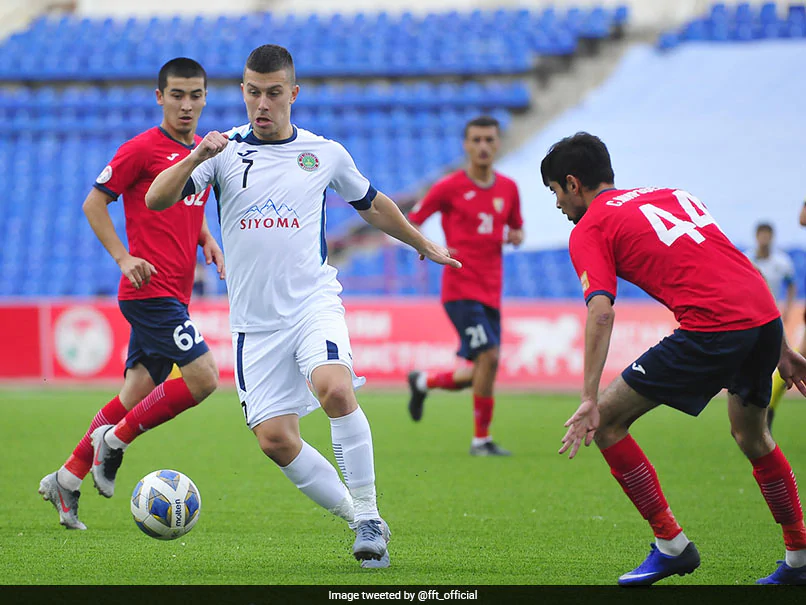

In [45]:
filename = path+'test_image_1.jpg'
print(get_image_caption(filename,img_caption_model))
display(Image(filename))

 A Dog Be Run In The Sand 


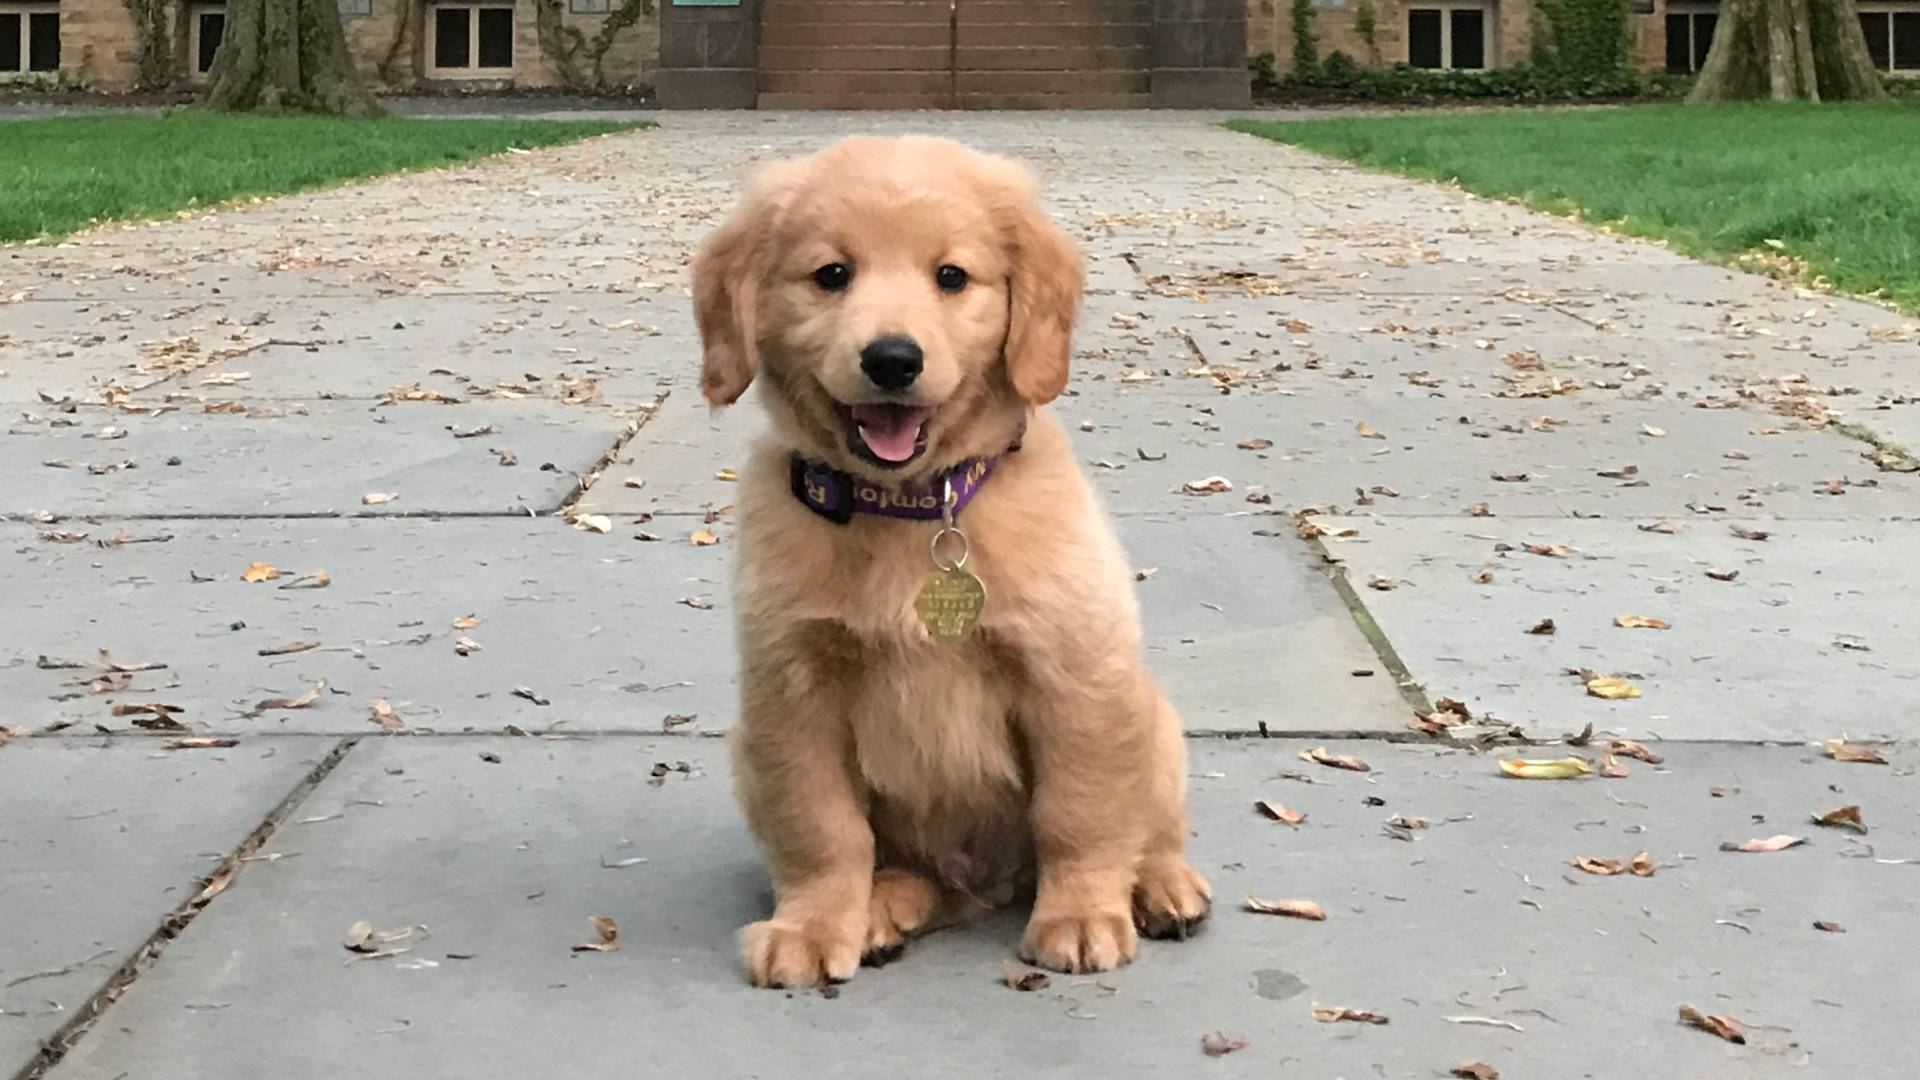

In [46]:
filename = path+'test_image_2.jpg'
print(get_image_caption(filename,img_caption_model))
display(Image(filename))

 A Boy In A Blue Shirt Be Jump Into A Pool 


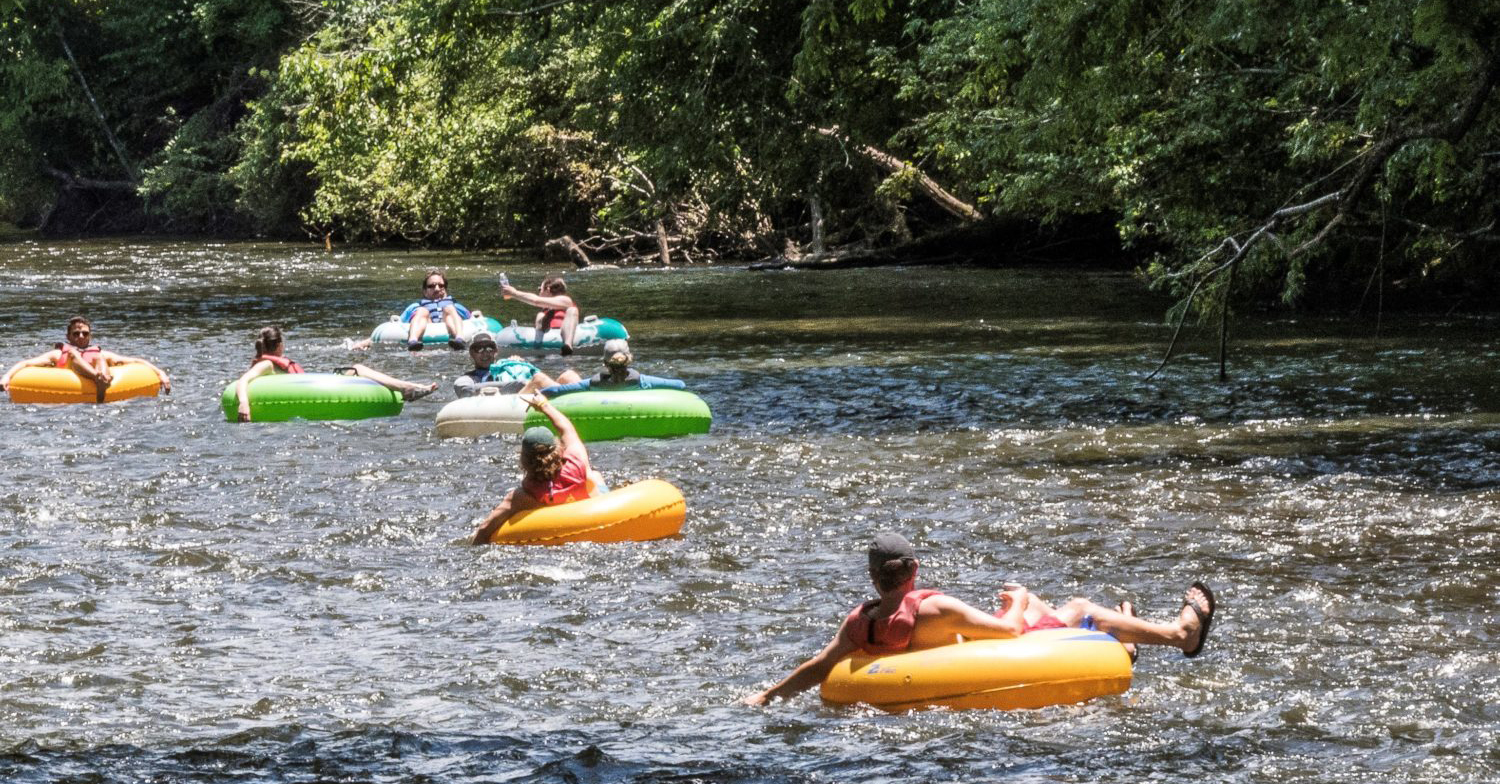

In [47]:
filename = path+'test_image_3.jpg'
print(get_image_caption(filename,img_caption_model))
display(Image(filename))

**Question 2: Implement the minimal vanilla recurrent neural network to learn the parity function.**

* Let us define a sequence parity function as a function that takes in a sequence of binary inputs and returns a sequence indicating the number of 0’s in the input so far; specifically, if at time t the 0’s in the input so far is even it returns 1, and 0 if it is odd. 
* For example, given input sequence [0, 1, 0, 1, 1, 0], the parity sequence is [0, 0, 1, 1, 1, 0]. 

In [103]:
import tensorflow.keras as keras
from numpy import random
import numpy as np
import tensorflow as tf

In [104]:
demo_model = keras.Sequential()
demo_model.add(keras.layers.SimpleRNN(10, input_shape=(1,10), activation='relu'))
demo_model.add(keras.layers.Dense(units=10, activation='sigmoid'))

demo_model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate=0.002), metrics=['accuracy'])

In [105]:
demo_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_7 (SimpleRNN)    (None, 10)                210       
                                                                 
 dense_7 (Dense)             (None, 10)                110       
                                                                 
Total params: 320
Trainable params: 320
Non-trainable params: 0
_________________________________________________________________


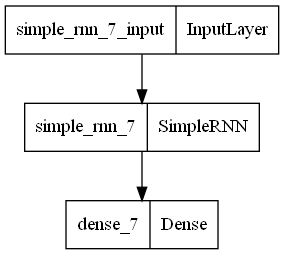

In [106]:
tf.keras.utils.plot_model(demo_model)

In [107]:
def generate_random_input(size):
    return random.randint(2, size=(size))

In [108]:
def generate_sequence_parity(x):
    y = []
    if(x[0] == 0):
        y.append(0)
    else:
        y.append(1)
    for i in range (1,len(x)):
        prev_num = y[i-1]
        if(x[i]==0):
            if(prev_num == 0):
                prev_num = 1
            else:
                prev_num = 0
        y.append(prev_num)
    return y

In [109]:
x = np.array([0, 1, 0, 1, 1, 0])
y = generate_sequence_parity(x)
print(y)

[0, 0, 1, 1, 1, 0]


In [110]:
x_train = []
y_train = []
for i in range (0, 10000):
    x = generate_random_input(10)
    x_train.append(x)
    y = generate_sequence_parity(x)
    y_train.append(np.array(y))

In [111]:
y_train[:5]

[array([1, 0, 1, 0, 0, 1, 1, 0, 0, 1]),
 array([1, 0, 1, 0, 0, 0, 0, 0, 1, 0]),
 array([1, 1, 0, 0, 0, 1, 1, 0, 1, 0]),
 array([0, 0, 1, 0, 1, 0, 1, 1, 1, 1]),
 array([1, 1, 0, 0, 0, 1, 1, 1, 0, 0])]

In [112]:
# Reshape the input to the required sample_size x time_steps x features 
x_train = np.reshape(x_train,(10000, 1, 10))

In [113]:
x_train[:2]

array([[[1, 0, 0, 0, 1, 0, 1, 0, 1, 0]],

       [[1, 0, 0, 0, 1, 1, 1, 1, 0, 0]]])

In [114]:
y_train = np.reshape(y_train,(10000, 1, 10))

In [115]:
y_train[:2]

array([[[1, 0, 1, 0, 0, 1, 1, 0, 0, 1]],

       [[1, 0, 1, 0, 0, 0, 0, 0, 1, 0]]])

In [116]:
demo_model.fit(x_train, y_train, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
10000/10000 - 10s - loss: 0.2029 - accuracy: 0.8138 - 10s/epoch - 982us/step
Epoch 2/10
10000/10000 - 11s - loss: 0.1722 - accuracy: 0.8787 - 11s/epoch - 1ms/step
Epoch 3/10
10000/10000 - 11s - loss: 0.1580 - accuracy: 0.7674 - 11s/epoch - 1ms/step
Epoch 4/10
10000/10000 - 10s - loss: 0.1507 - accuracy: 0.7526 - 10s/epoch - 1ms/step
Epoch 5/10
10000/10000 - 11s - loss: 0.1485 - accuracy: 0.7835 - 11s/epoch - 1ms/step
Epoch 6/10
10000/10000 - 11s - loss: 0.1474 - accuracy: 0.8170 - 11s/epoch - 1ms/step
Epoch 7/10
10000/10000 - 10s - loss: 0.1465 - accuracy: 0.8307 - 10s/epoch - 1ms/step
Epoch 8/10
10000/10000 - 11s - loss: 0.1446 - accuracy: 0.8422 - 11s/epoch - 1ms/step
Epoch 9/10
10000/10000 - 11s - loss: 0.1426 - accuracy: 0.8880 - 11s/epoch - 1ms/step
Epoch 10/10
10000/10000 - 11s - loss: 0.1414 - accuracy: 0.8956 - 11s/epoch - 1ms/step


In [117]:
x5 = np.array([ 1,1,1,1,0, 1, 0, 1, 1, 0])
x_input_5 = np.reshape(x5,(1, 1, 10))

In [118]:
y5 = generate_sequence_parity(x5)
print(y5)

[1, 1, 1, 1, 0, 0, 1, 1, 1, 0]


In [119]:
y_pred_model_5 = demo_model.predict(x_input_5)
np.round(y_pred_model_5)

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 0.]], dtype=float32)

In [120]:
x5 = np.array([1, 1, 0, 0, 1, 1, 0, 0, 1, 0])
x_input_5 = np.reshape(x5,(1, 1, 10))

In [121]:
y5 = generate_sequence_parity(x5)
print(y5)

[1, 1, 0, 1, 1, 1, 0, 1, 1, 0]


In [122]:
y_pred_model_5 = demo_model.predict(x_input_5)
np.round(y_pred_model_5)

array([[1., 1., 0., 1., 1., 0., 1., 0., 1., 1.]], dtype=float32)